In [2]:
# Data Processing Packages
import csv
import numpy as np 
import pandas as pd
from random import randint
import random
from itertools import cycle
import matplotlib.pyplot as plt

# Date Packages
from datetime import date, datetime

# Machine Learning Packages
from sklearn import preprocessing

from keras.layers import *
from keras.models import *
from keras.layers import add

# Stat Packages
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Flask Packages
from flask import Flask, render_template, g, request, redirect, url_for

# Database Packages
import psycopg2

import sys
sys.path.append('../utils')

import db

In [4]:
taskid = '{date:%Y%m%d-%H%M%S}'.format( date=datetime.now()) 
print(taskid)

20190731-050222


## Get Stock Price

In [6]:
df_stock_price_all = db.show_stock_price()
df_stock_price_all = df_stock_price_all.sort_values(by=['stockcode','date'])

In [7]:
df_stock_price_all.head()

,stockcode,date,open,high,low,close,adjclose,volume
9637,0005.HK,2018-01-02,80.55,81.30,80.45,81.30,74.292,37060582.0
9680,0005.HK,2018-01-03,81.30,81.45,80.80,80.95,73.972,21680762.0
9723,0005.HK,2018-01-04,80.90,81.05,80.35,80.50,73.561,17205111.0
9766,0005.HK,2018-01-05,81.05,81.20,80.60,80.80,73.835,15902273.0
9809,0005.HK,2018-01-08,80.50,80.80,80.05,80.50,73.561,21354440.0


In [8]:
# Create Empty Dataframe
df_stock_price = pd.DataFrame(columns=df_stock_price_all.columns.tolist()+['target'] )

# Calculate rolling average as target for each stock
for stock in df_stock_price_all.stockcode.unique():
    df_tmp = df_stock_price_all[df_stock_price_all['stockcode']==stock].copy()
    df_tmp['target'] = df_tmp['adjclose'].rolling(window=5).mean()
    df_stock_price = df_stock_price.append(df_tmp)

df_stock_price = df_stock_price[df_stock_price.target.notnull()]

In [9]:
df_stock_price.tail()

,stockcode,date,open,high,low,close,adjclose,volume,target
9422,6818.HK,2019-07-25,3.58,3.62,3.56,3.62,3.62,6596525.0,3.578
9465,6818.HK,2019-07-26,3.60,3.63,3.57,3.61,3.61,5416146.0,3.582
9508,6818.HK,2019-07-29,3.60,3.63,3.58,3.61,3.61,4383325.0,3.592
9551,6818.HK,2019-07-30,3.62,3.66,3.59,3.60,3.60,8732459.0,3.600
9594,6818.HK,2019-07-31,3.60,3.61,3.57,3.59,3.59,1421345.0,3.606


In [10]:
categorical_cols = ['stockcode','date']
numerical_cols = ['open', 'high', 'low', 'close', 'adjclose', 'volume', 'target']

In [11]:
def normalize_df(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df[numerical_cols] = min_max_scaler.fit_transform(df[numerical_cols])
    return df

In [12]:
def get_df(seq_length):
    
    # Pick A Random Stock 
    while True:
        stock = random.choice(df_stock_price.stockcode.unique())
        df = df_stock_price[df_stock_price['stockcode']==stock].copy()
        if len(df) > seq_length:
            break
    
    # Get X, y of the stock
    r = randint(0, len(df)-seq_length-1) 
    
    df = df[numerical_cols][r:r+seq_length+1].copy()
    df = normalize_df(df)
    
    X = df[0:seq_length].values
    y = list(df['target'])[seq_length]
    
    return X, y

In [13]:
seq_length = 50

In [14]:
def sample(num_of_sample):

    # Initialize sample vectors
    X = np.zeros((num_of_sample, seq_length, len(numerical_cols)))
    y = np.zeros((num_of_sample))
    
    n = 0
    while n < num_of_sample:
        # Generate random samples
        X_single, y_single = get_df(seq_length)

        X[n] = X_single
        y[n] = y_single

        n=n+1
        if n % 1000 == 0:
            print('sample:', n)

    return X, y
    

In [15]:
X_train, y_train = sample(100000)

sample: 1000
sample: 2000
sample: 3000
sample: 4000
sample: 5000
sample: 6000
sample: 7000
sample: 8000
sample: 9000
sample: 10000
sample: 11000
sample: 12000
sample: 13000
sample: 14000
sample: 15000
sample: 16000
sample: 17000
sample: 18000
sample: 19000
sample: 20000
sample: 21000
sample: 22000
sample: 23000
sample: 24000
sample: 25000
sample: 26000
sample: 27000
sample: 28000
sample: 29000
sample: 30000
sample: 31000
sample: 32000
sample: 33000
sample: 34000
sample: 35000
sample: 36000
sample: 37000
sample: 38000
sample: 39000
sample: 40000
sample: 41000
sample: 42000
sample: 43000
sample: 44000
sample: 45000
sample: 46000
sample: 47000
sample: 48000
sample: 49000
sample: 50000
sample: 51000
sample: 52000
sample: 53000
sample: 54000
sample: 55000
sample: 56000
sample: 57000
sample: 58000
sample: 59000
sample: 60000
sample: 61000
sample: 62000
sample: 63000
sample: 64000
sample: 65000
sample: 66000
sample: 67000
sample: 68000
sample: 69000
sample: 70000
sample: 71000
sample: 72000
s

In [31]:
x = Input((seq_length,len(numerical_cols)))

In [28]:
X_train.shape

(100000, 50, 7)

In [35]:
Y = LSTM(units=20, return_sequences = True)(x)
Y = Dropout(0.3)(Y)
Y = LSTM(units=20, return_sequences = True)(Y)
Y = Dropout(0.3)(Y)
Y = LSTM(units=20)(Y)
Y = Dense(20)(Y)
Y = Dense(20)(Y)
Y = Dense(1)(Y)

In [36]:
model = Model(inputs=[x], outputs=Y)
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50, 7)             0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 50, 20)            2240      
_________________________________________________________________
dropout_9 (Dropout)          (None, 50, 20)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 50, 20)            3280      
_________________________________________________________________
dropout_10 (Dropout)         (None, 50, 20)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dense_9 (Dense)              (None, 20)                420       
__________

In [38]:
model.fit(X_train, y_train, validation_split=0.1, epochs = 2, batch_size = 32)

Train on 90000 samples, validate on 10000 samples
Epoch 1/2
90000/90000 [==============================] - 296s 3ms/step - loss: 0.0096 - val_loss: 0.0025
Epoch 2/2
90000/90000 [==============================] - 284s 3ms/step - loss: 0.0037 - val_loss: 0.0023


In [43]:
model.save("TA model v2.h5")
print("Saved model to disk")

Saved model to disk


### Check Prediction

In [361]:
for stock in df_stock_price_all.stockcode.unique():
    print(stock)

0005.HK
0011.HK
0023.HK
0222.HK
0416.HK
0440.HK
0626.HK
0939.HK
0998.HK
1111.HK
1216.HK
1288.HK
1398.HK
1551.HK
1578.HK
1658.HK
1963.HK
1988.HK
2016.HK
2066.HK
2356.HK
2388.HK
2888.HK
3328.HK
3618.HK
3698.HK
3866.HK
3968.HK
3988.HK
6122.HK
6138.HK
6196.HK
6818.HK


### Predict Stock Price

In [399]:
list(df['target'])[378]

3.265999999999994

In [40]:
def get_df_pred(stock):
    
    num_of_sample = 100
    
    X = np.zeros((num_of_sample + 1, seq_length, len(numerical_cols)))
    y = np.zeros((num_of_sample + 1))
    
    # Pick A Random Stock 
    df = df_stock_price[df_stock_price['stockcode']==stock].copy()
    df = normalize_df(df)
    
    print('df:',len(df))
    
    # Get X, y of the stock
    n = 0
    while n < num_of_sample:
        remain = num_of_sample - n 
        X[n] = df[numerical_cols][-seq_length-remain:-remain].values
        y[n] = list(df['target'])[-remain]
        n = n + 1
    
    X[num_of_sample] = df[numerical_cols][-seq_length:].values
    y[num_of_sample] = None
    return X, y

df: 381


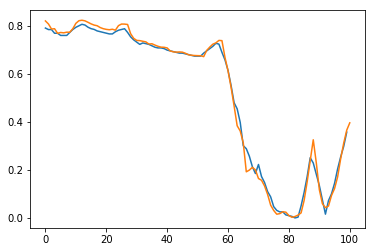

In [44]:
X_Ori, y_Ori = get_df_pred('1216.HK')
y_pred = model.predict(X_Ori)
plt.plot(y_Ori)
plt.plot(y_pred)